In [21]:
#External Imports for File Management
import numpy as np
import os

#Local imports
from PythonPackage.models.fpAM import FPAM
from PythonPackage.models.hdAM import HDAM
from PythonPackage.models.nodeAM import NODEAM
from PythonPackage.data_pipeline import Pipeline
from PythonPackage.tensor_analysis import VIP_tensor
from PythonPackage.figures import *

# Initialize the data pipeline
rootpath = os.getcwd()
mainData = Pipeline(rootpath, name = 'final_')

## Experimentation

### Visualize the Models

In [ ]:
mainData.visualizeall(Hcells = False,
                      Icells = True,
                      FPAM = False,
                      HDAM = True,
                      NODEAM = False,)

### Training the Models

In [ ]:
mainData.training(FPAM = False,
                  HDAM = True,
                  NODEAM = False,

                  Hcells = False,
                  Icells = True,

                  n_epochs = 2500,
                  method = 'Nelder-Mead', #L-BFGS-B
                  visualize = True,

                  data_sets = [0])

In [172]:
mainData.save_parameters(FPAM=False,
                         HDAM = True,
                         NODEAM = False,
                         name = 'final_')

### Data Augmentation

In [197]:
mainData.visualize_augmented_data(
    FPAM = False,
    HDAM = False,
    NODEAM = False
)

In [191]:
mainData.augmentation(
    n_aug = 1000, 
    num_timepoints = 20, 
    
    error = [0.05, 0.01, 0.025], #[0.1, 0.01, 0.02], 
    
    Hcells = True, 
    Icells = True, 
    
    FPAM = False, 
    HDAM = True, 
    NODEAM = False, 
    
    visualize = False
)

In [196]:
mainData.save_augmented_datasets(
    name = '',
    FPAM = False, 
    HDAM = True, 
    NODEAM = False,
)

### Regression

In [ ]:
mainData.importance_regression()

In [193]:
mainData.save_VIP_tensor('fixed_hdam_')

### Batch Sizes

In [ ]:
batch_sizes = [100, 125, 150, 200, 250, 300, 400, 500, 750, 1000]

def batch_size_testing(batch_sizes):

    # Storage
    importance_tensors = []
    validation_errors = []
        
    for current_batch_size in batch_sizes:

        print('Starting Batch Size: ', current_batch_size)
        while True:
            try:
                mainData.augmentation(
                                n_aug = current_batch_size,
                                num_timepoints = 20,
                                
                                error = [0.05, 0.01, 0.025],
                                
                                Hcells = True,
                                Icells = True,
                                
                                FPAM = True,
                                HDAM = True,
                                NODEAM = True,
                                
                                visualize = False
                            )
                
                mainData.importance_regression()
                importance_tensors.append(mainData.importance)

                val_error = mainData.mse_regression()
                validation_errors.append(val_error)

                break
            
            #Re-augment data if error is encountered
            except (ValueError, TypeError) as e:
                print(f"Error encountered: {e}. Re-augmenting data...")
                continue

    importance_array = np.array(importance_tensors)
    validation_array = np.array(validation_errors)

    return importance_array, validation_array

new_imp, new_val = batch_size_testing(batch_sizes)

## Results and Figures

### Figure 2

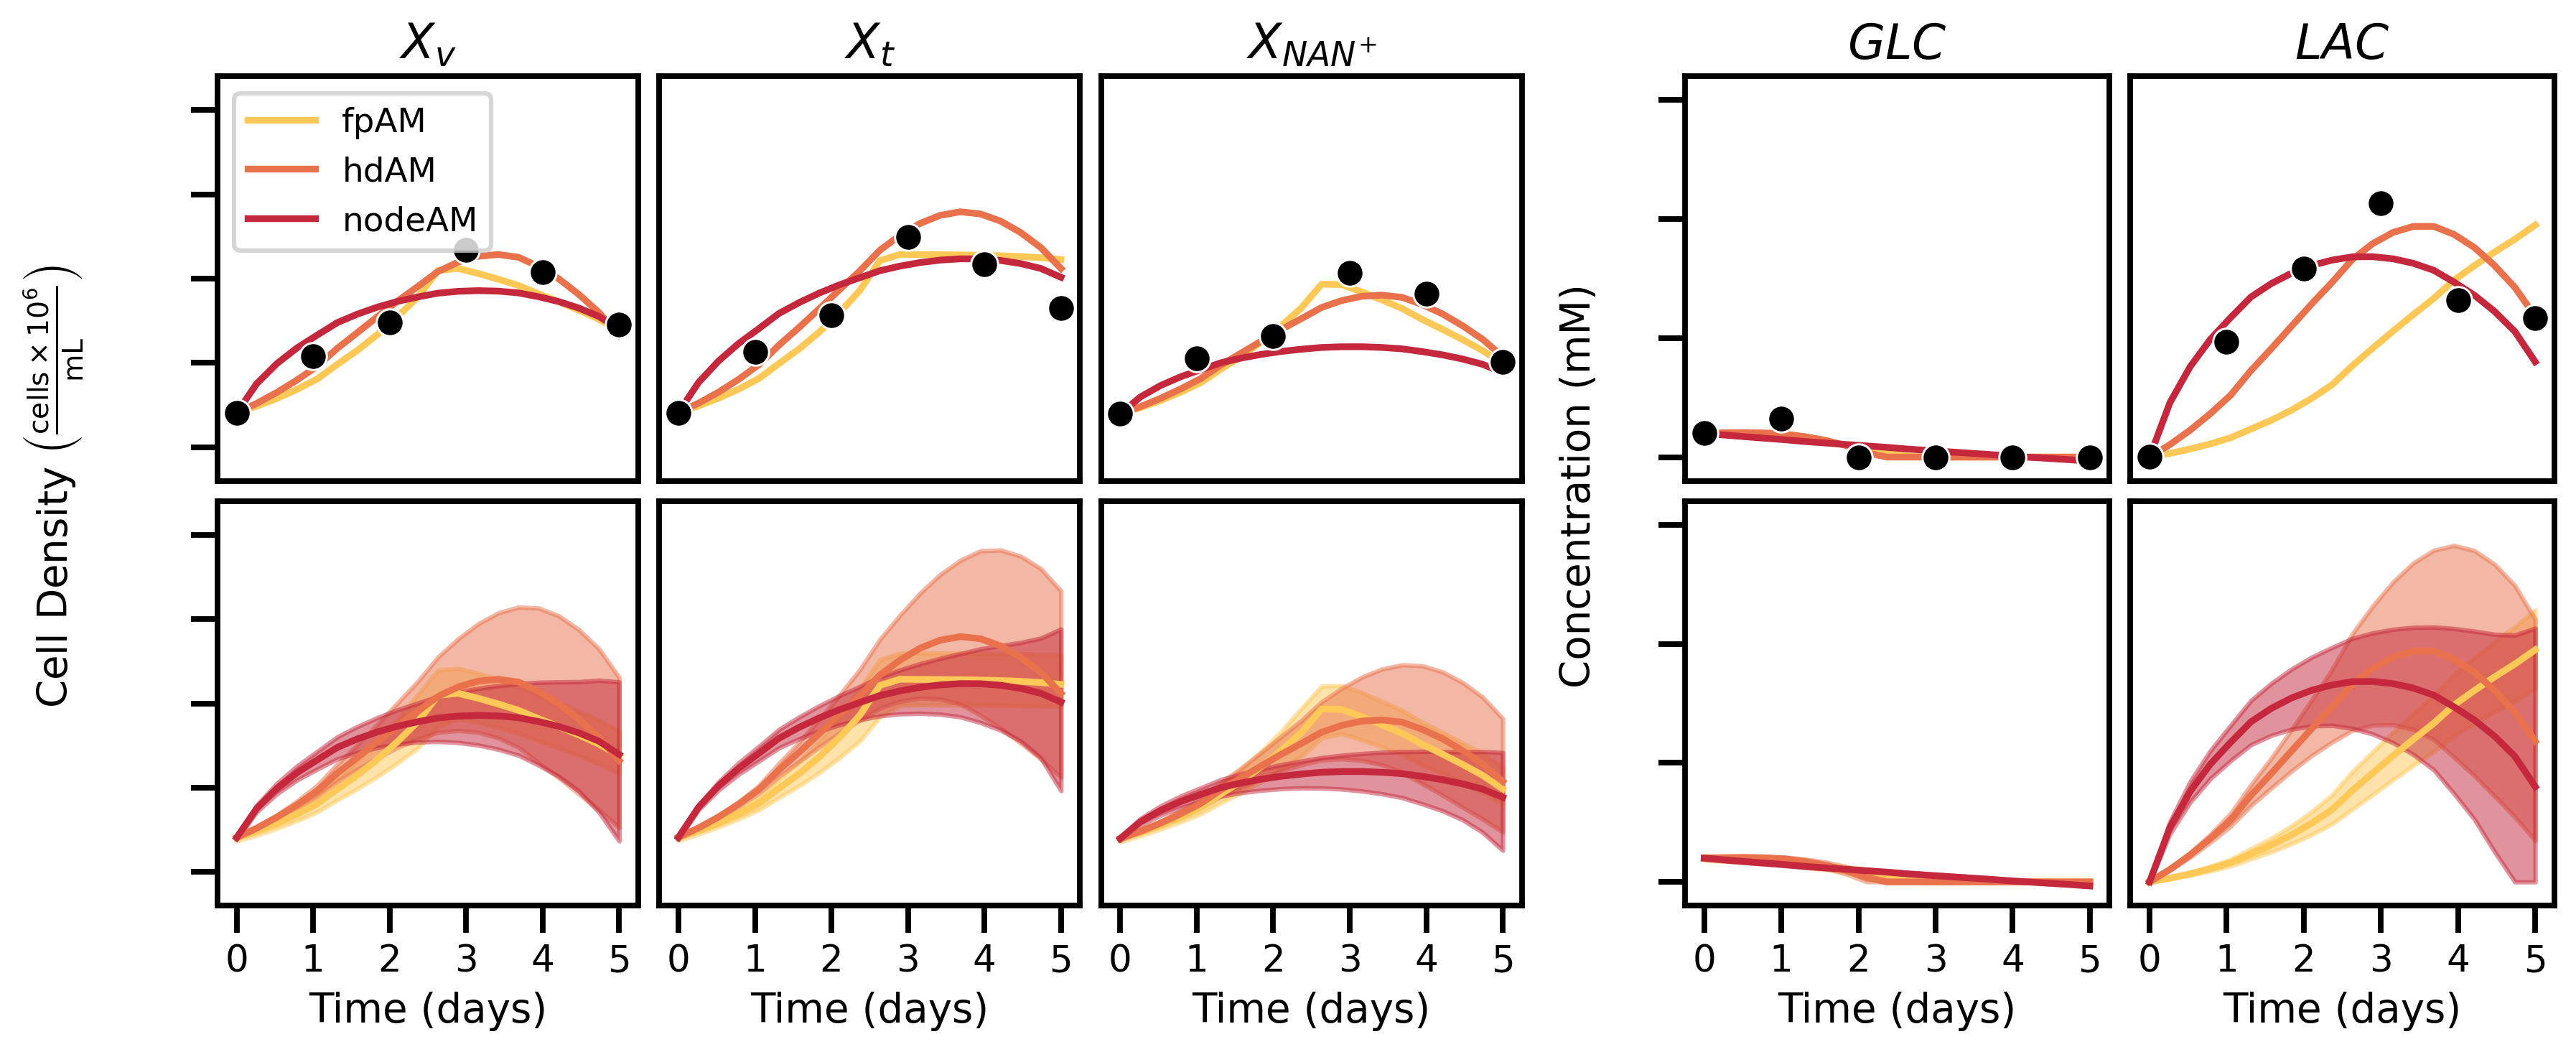

In [20]:
development_figure(
        index = [0, 0],
        mainData = mainData,
        size = (14, 5),
        scale = 0.75,
        fpm_color = '#FFC857',
        hdm_color = '#E9724C',
        node_color = '#C5283D',
        opacity = 0.5
)

/Users/owenskriloff/anaconda3/lib/python3.11/site-packages/torchdiffeq/_impl/misc.py:15: UserWarning: AdamsBashforthMoulton: Unexpected arguments {'dtype': torch.float32}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/Users/owenskriloff/anaconda3/lib/python3.11/site-packages/torchdiffeq/_impl/fixed_adams.py:220: UserWarning: Functional iteration did not converge. Solution may be incorrect.
  warnings.warn('Functional iteration did not converge. Solution may be incorrect.')


{(0, 1): 0.0407, (0, 2): 0.0086, (1, 2): 0.5323}
{(0, 1): 0.9605, (0, 2): 0.6395, (1, 2): 0.7883}


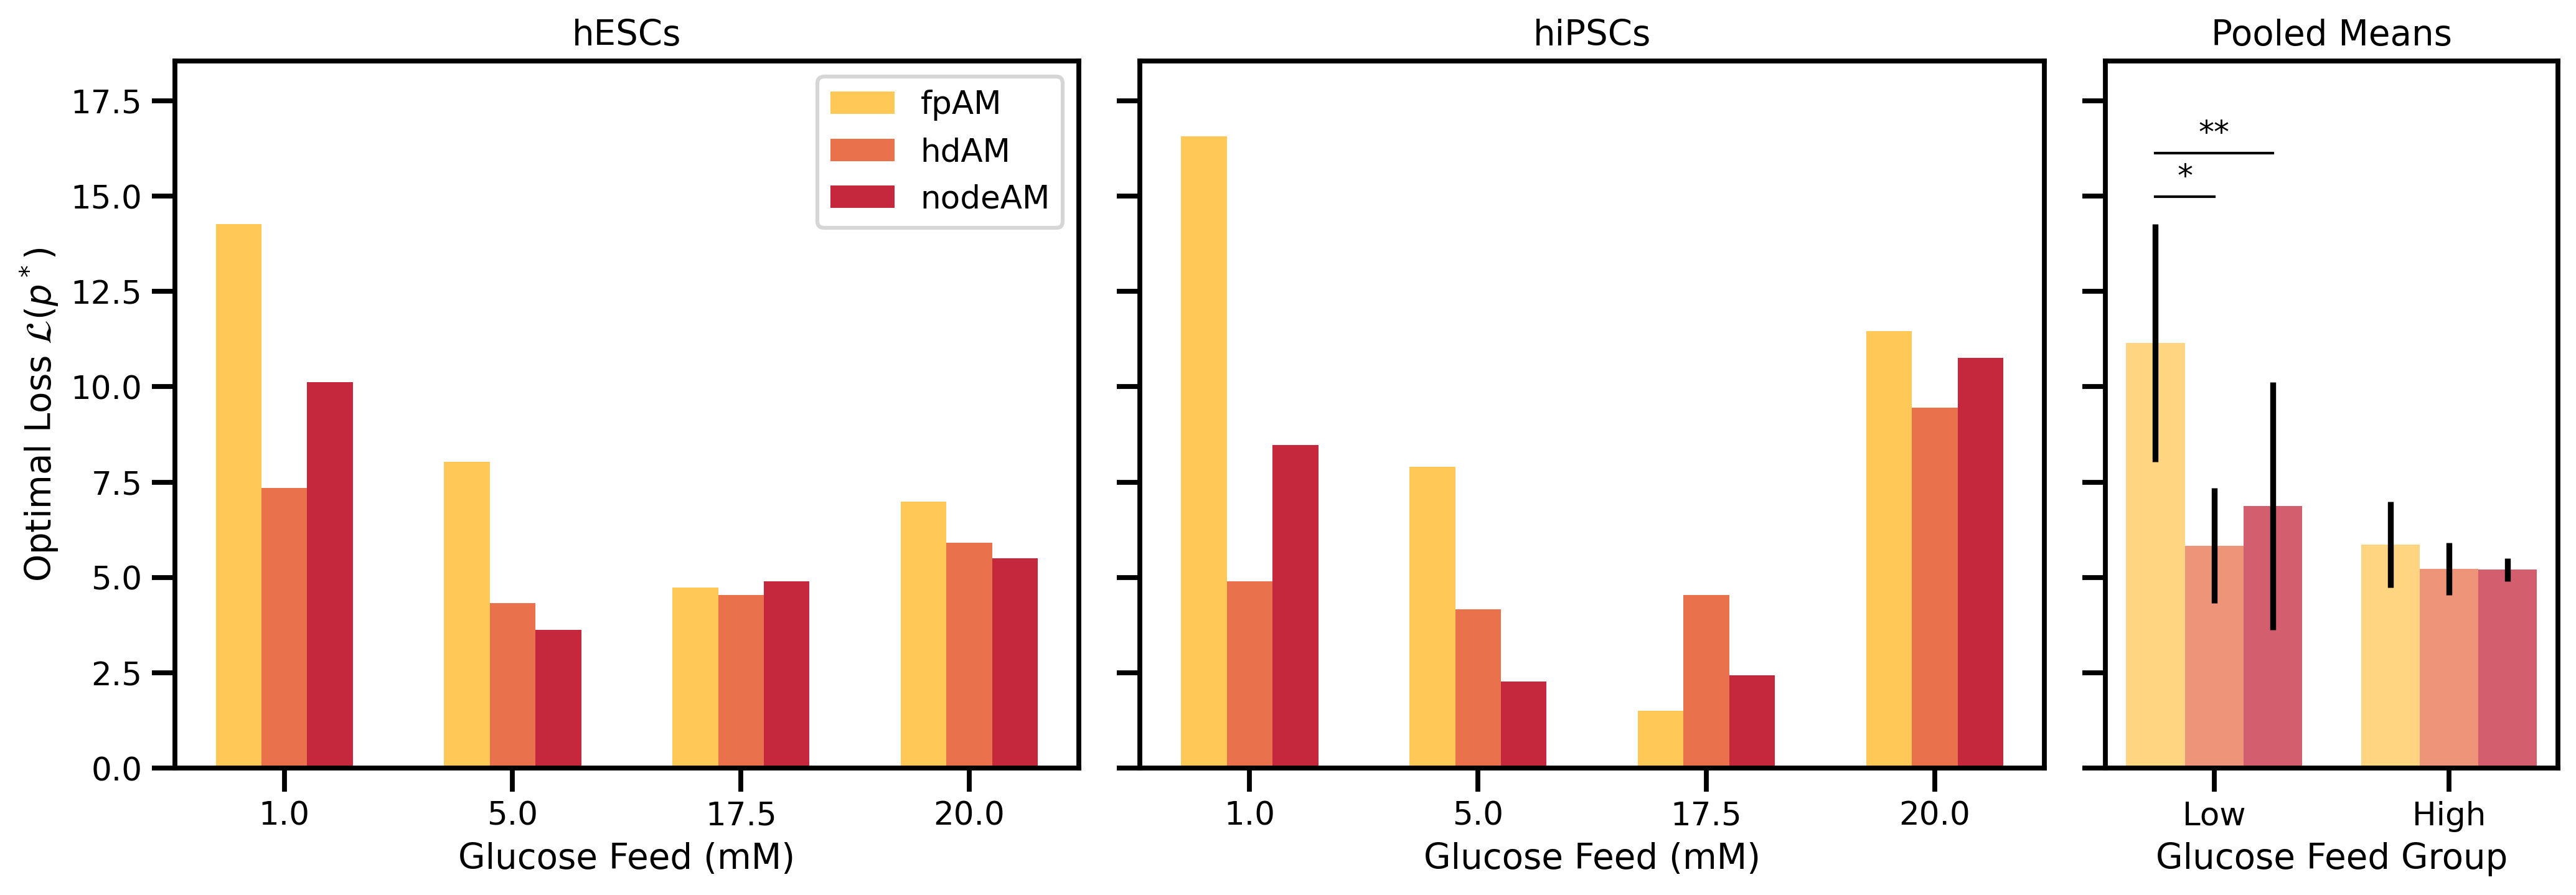

In [16]:
model_accuracy(mainData, size=(14, 5), scale=0.75)

{(0, 1): 0.08822186515542753, (0, 2): 0.08865428204869284, (1, 2): 0.0021557522938421073}
{(0, 1): 9.189275508964409e-14, (0, 2): 1.7408186686008288e-09, (1, 2): 9.525411885105013e-07}
[ 0.51763901 -0.44140333]
0.8801080087321669


/Users/owenskriloff/Desktop/Thesis Code Clean/PythonPackage/figures.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


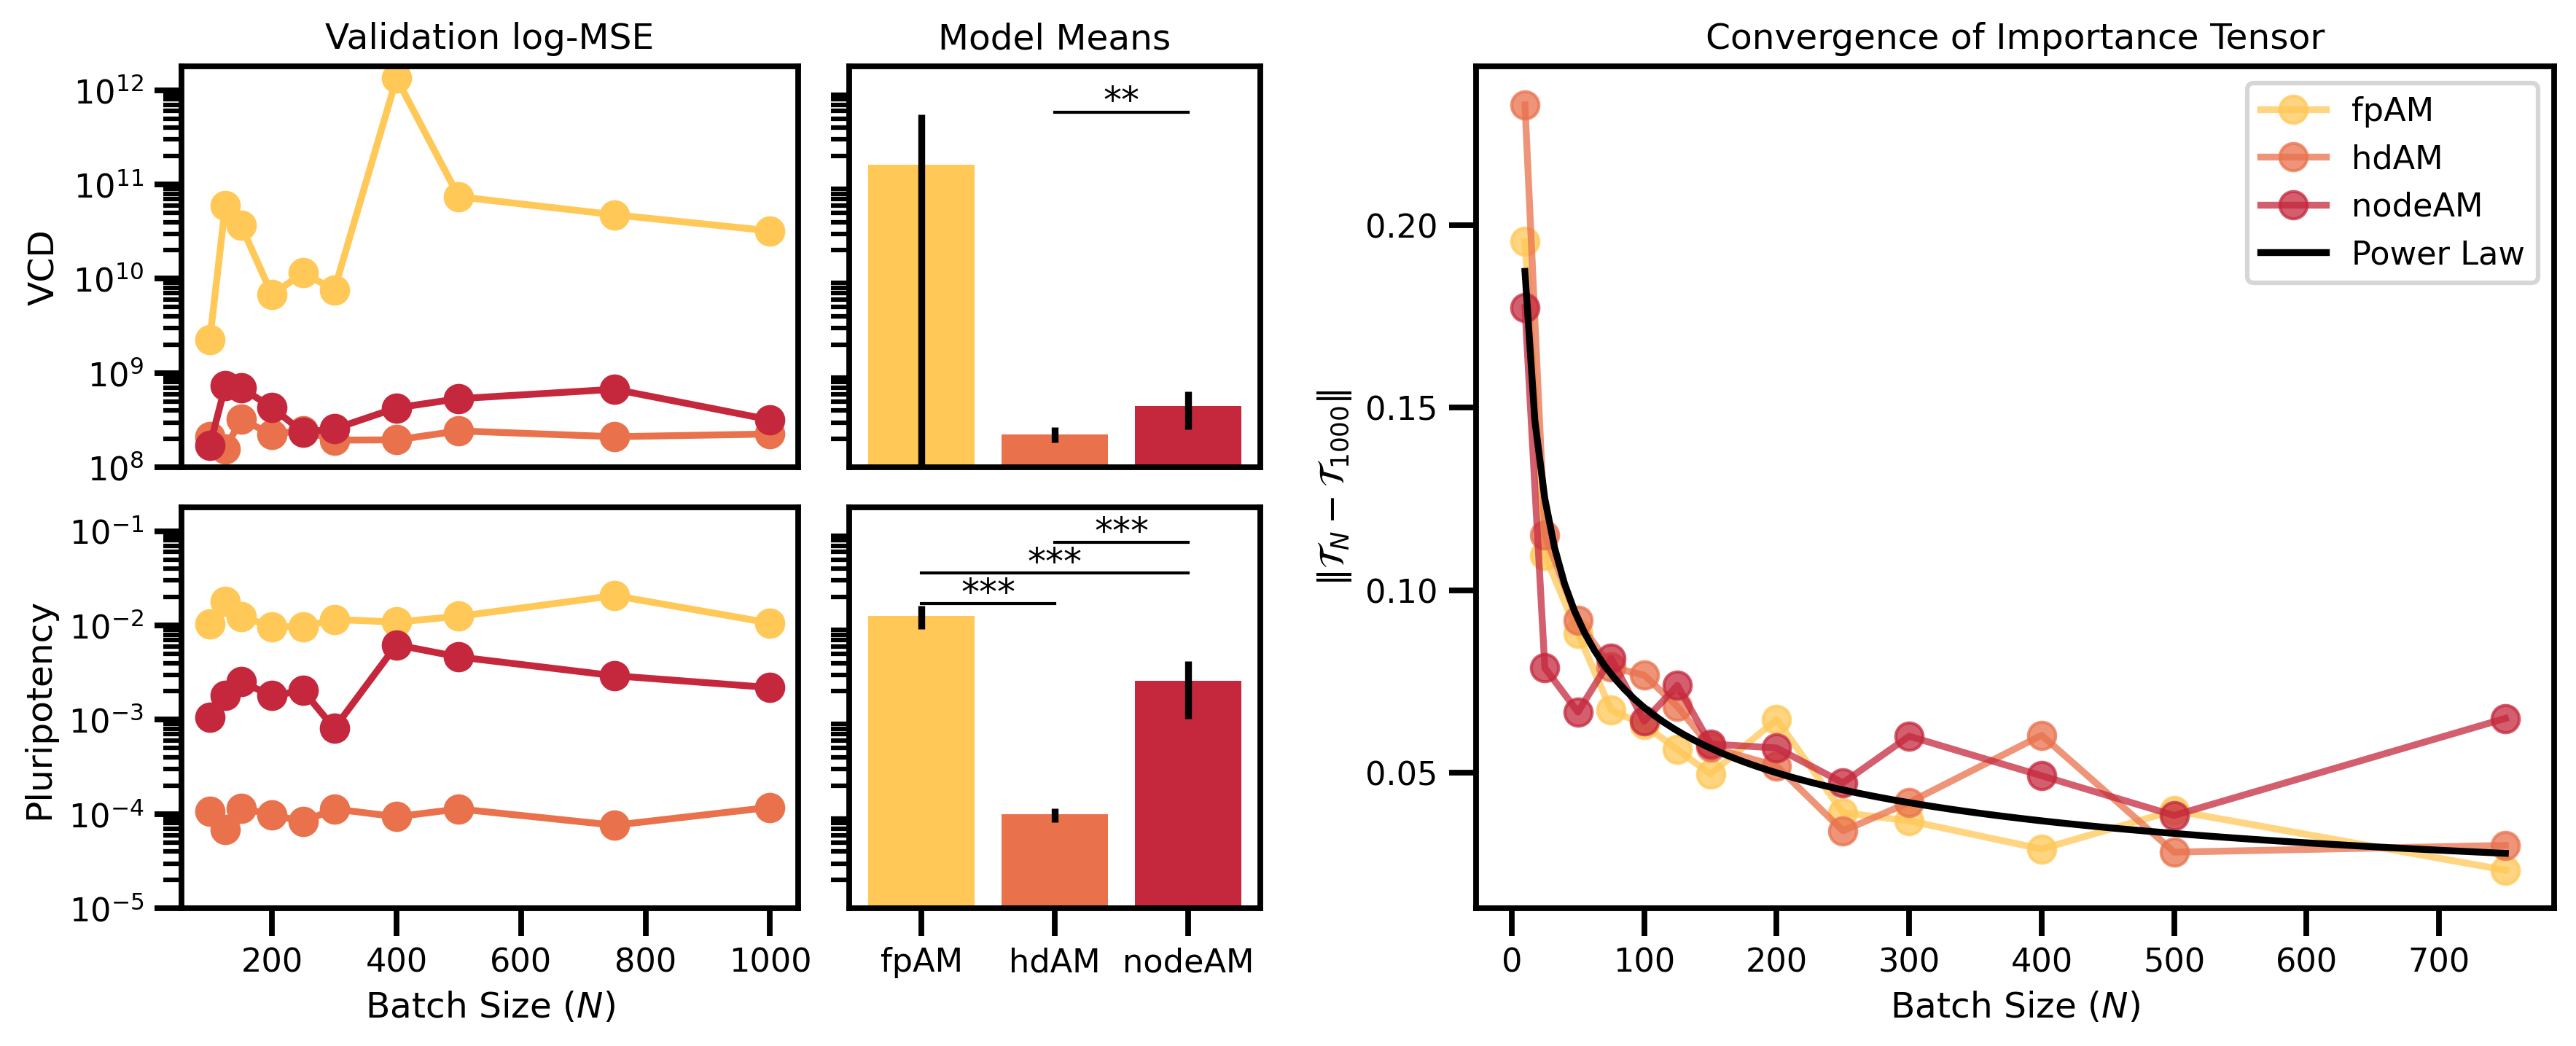

In [12]:
importance = np.load('Importance/final_imps.npy')
batches_importance = [10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500, 750, 1000]

validation = np.load('Importance/new_val.npy')
batches_validation = [100, 125, 150, 200, 250, 300, 400, 500, 750, 1000]

batch_size_plotting(validation, importance, batches_validation, batches_importance,
                    scale = 0.65, size = (14, 5))

### Tensor Analysis (FDA ANOVA)
$\mathcal{T} = [3,2,4,2,2,20]$
- 3 Models (FPAM, HDAM, NODEAM)
- 2 Cell Types (Hcells, Icells)
- 4 Glucose Feed Concentrations (1, 5, 17.5, 20 mM)
- 2 Critical Quality Attributes (CQAs)
- 2 Glycolytic Indicators (Glucose, Lactate)
- 20 Time Points

In [4]:
path = 'Importance/fixed_hdam_VIP_tensor.npy'
tensor = VIP_tensor(path)

print(np.shape(tensor.tensor))

#FDA-ANOVA Table
pvals, fstats = tensor.fda_anova_results()

pvals = np.array(pvals)
print(pvals)

0.012
(3, 2, 4, 2, 20)
[[0.665  0.176  0.012 ]
 [0.765  0.465  0.017 ]
 [0.847  0.1915 0.1025]]


### Figure 3

/Users/owenskriloff/Desktop/Thesis Code Clean/PythonPackage/figures.py:307: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


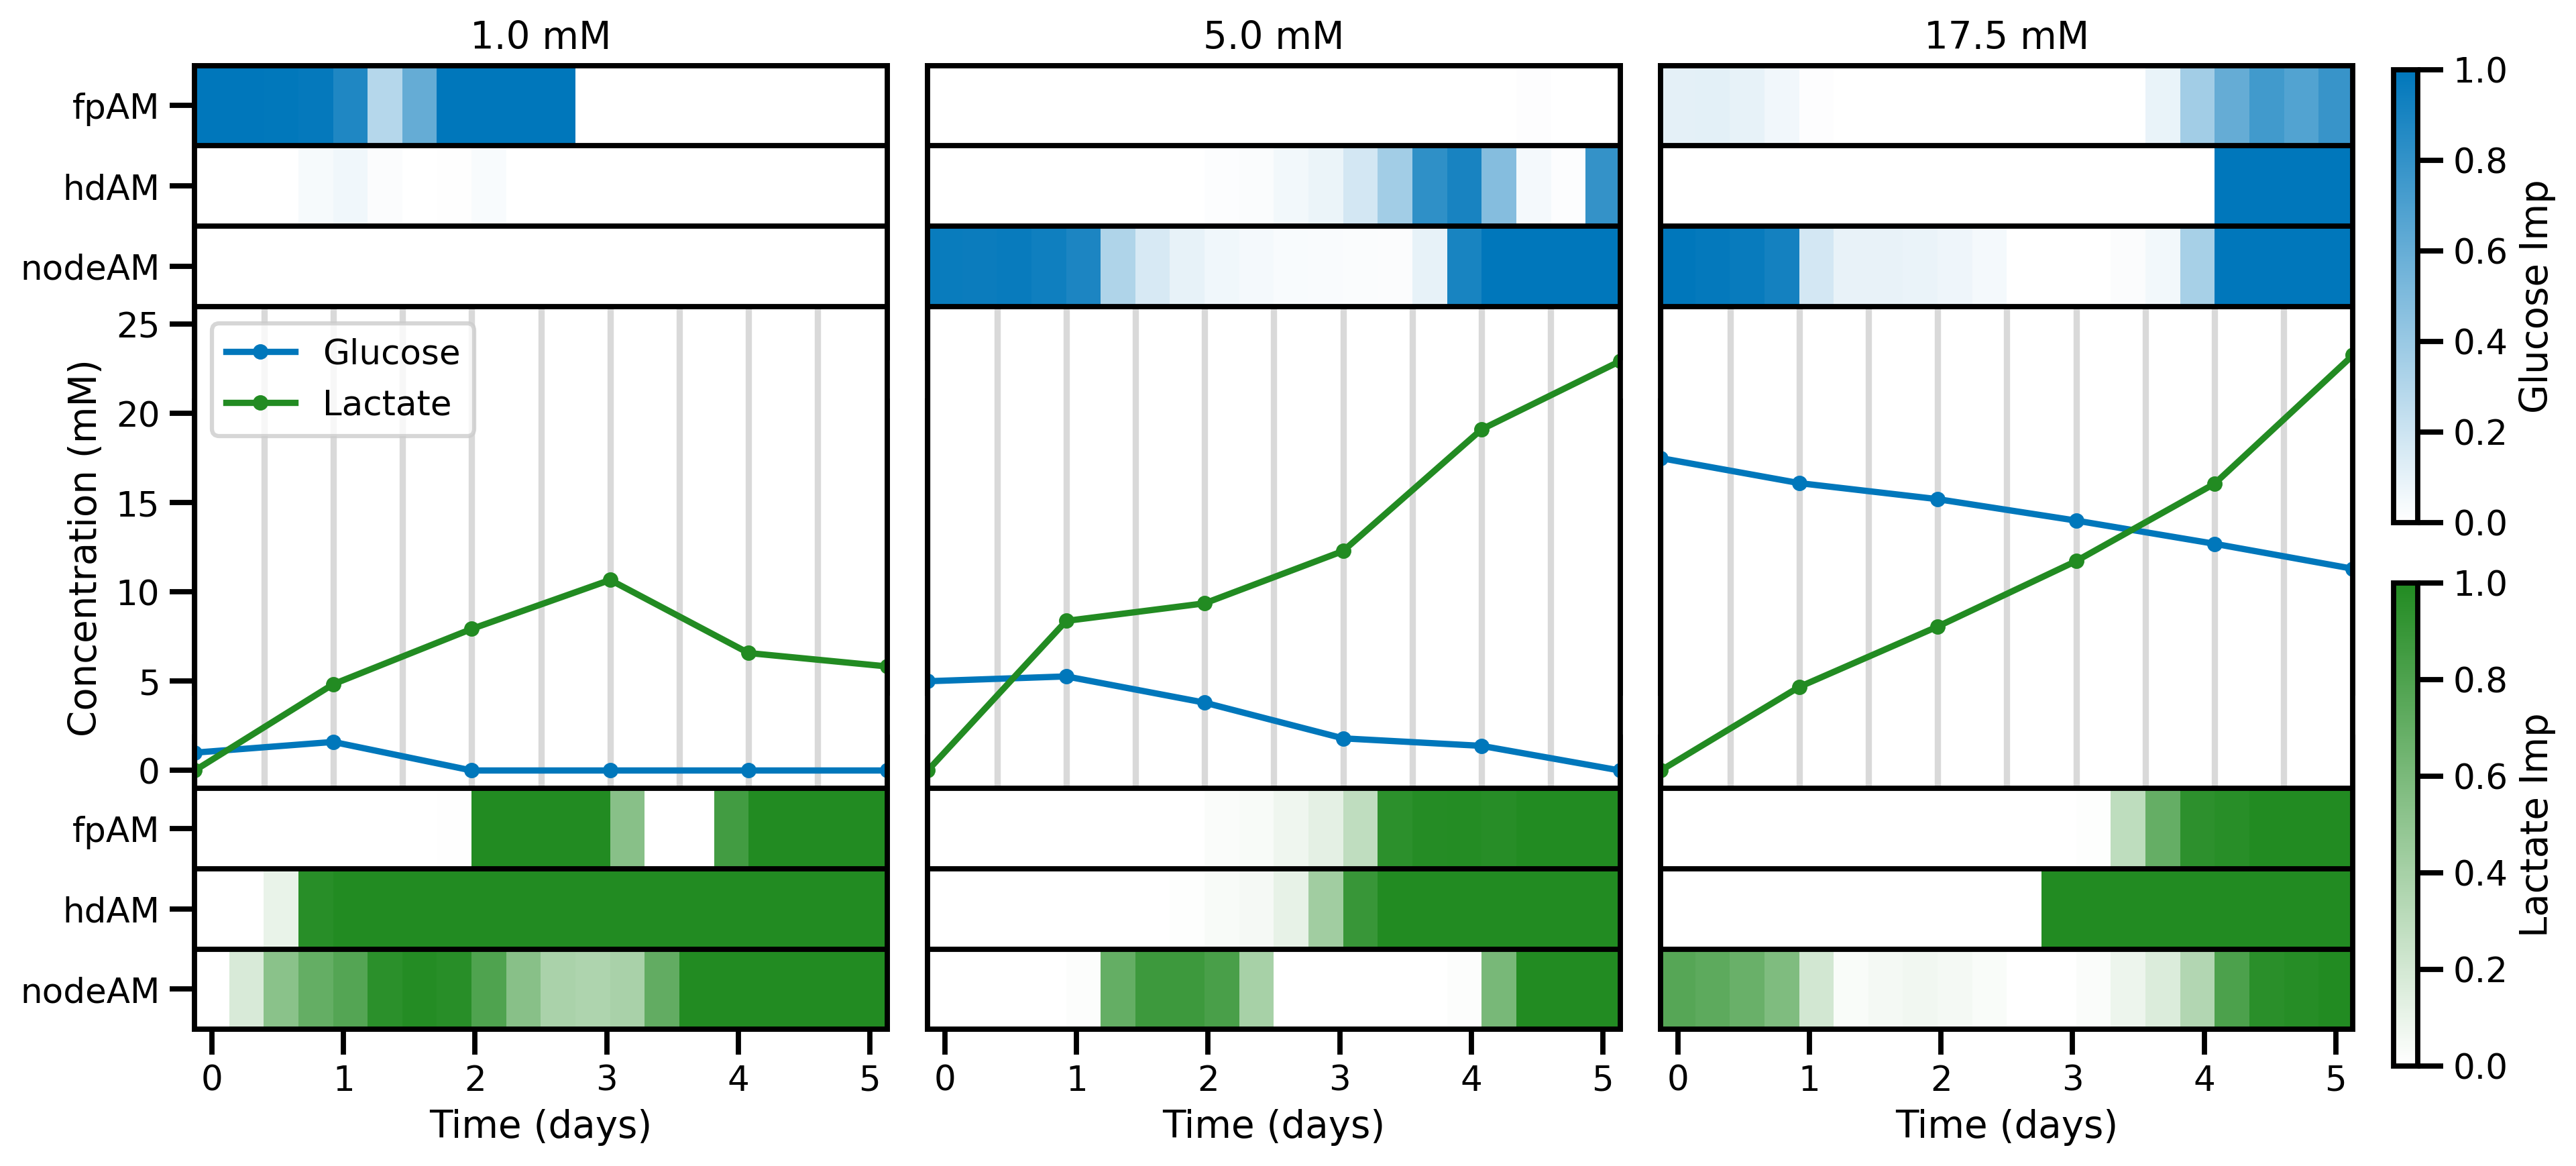

/Users/owenskriloff/Desktop/Thesis Code Clean/PythonPackage/figures.py:307: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


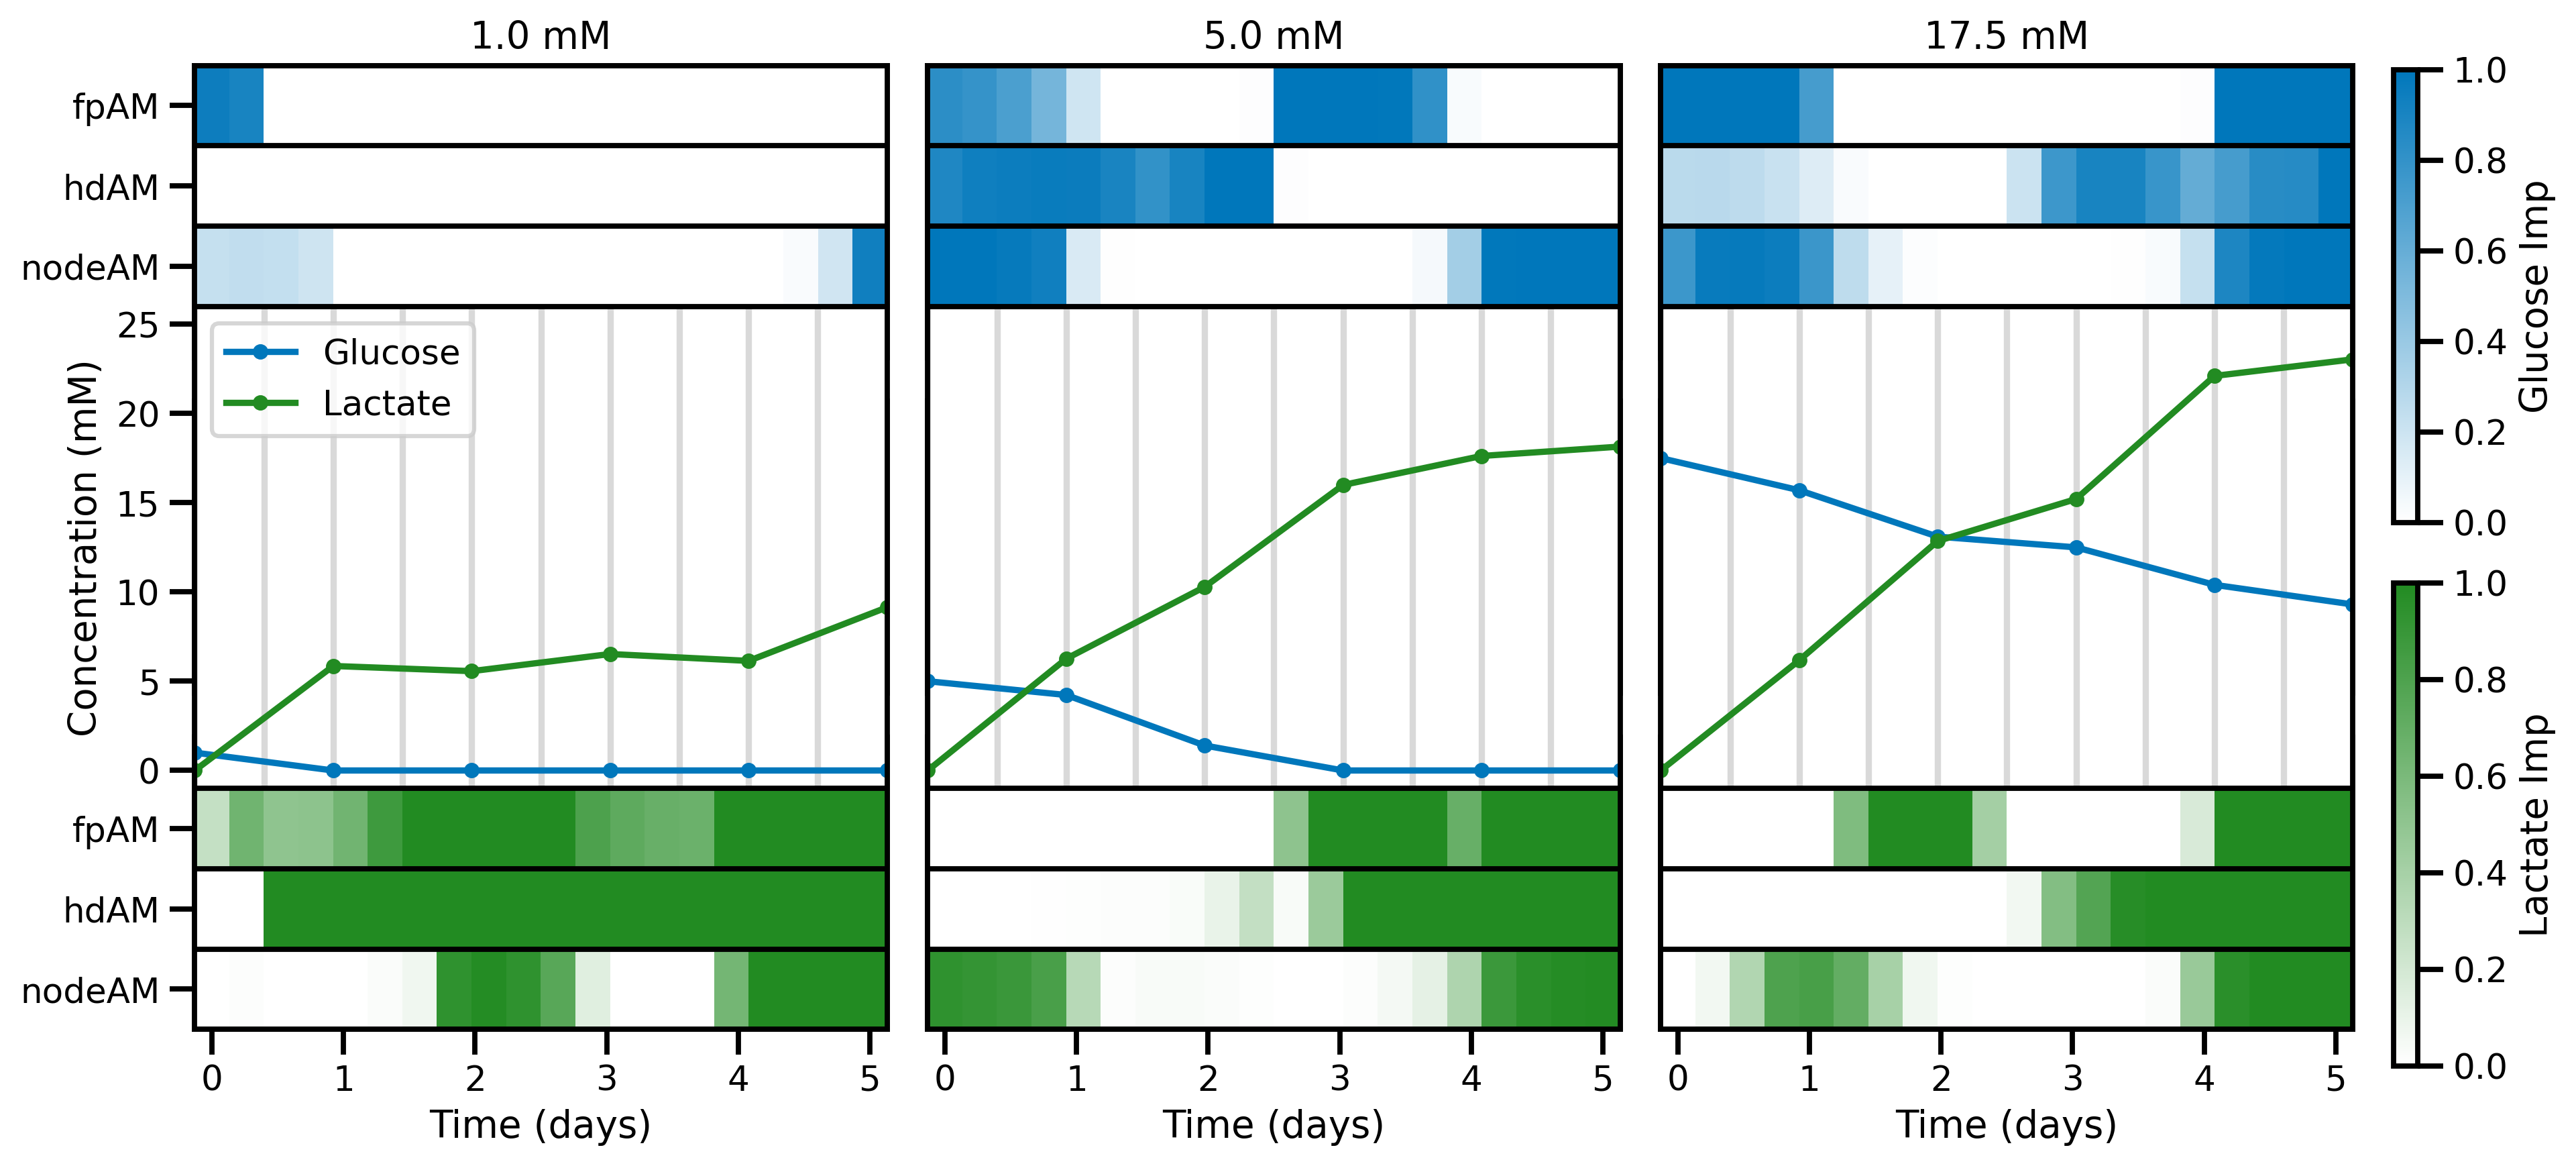

In [9]:
# Load tensor data
path = 'Importance/fixed_hdam_VIP_tensor.npy'
Tensor = np.load(path)

data_with_heatmaps(
    Tensor,
    mainData,
    cell_type = 'H',
    size = (12, 6),
    scale = 0.75,
    ratio = [0.5, 1, 0.5],
    colormap_glucose = LinearSegmentedColormap.from_list("white_to_glucose_black", ["white", "#0077BB"], N=256),
    colormap_lactate = LinearSegmentedColormap.from_list("white_to_lactate_black", ["white", "#228B22"], N=256),
    color_glc = '#0077BB',
    color_lac = '#228B22',
    ticks = False
    )

data_with_heatmaps(
    Tensor,
    mainData,
    cell_type = 'I',
    size = (12, 6),
    scale = 0.75,
    ratio = [0.5, 1, 0.5],
    colormap_glucose = LinearSegmentedColormap.from_list("white_to_glucose_black", ["white", "#0077BB"], N=256),
    colormap_lactate = LinearSegmentedColormap.from_list("white_to_lactate_black", ["white", "#228B22"], N=256),
    color_glc = '#0077BB',
    color_lac = '#228B22',
    ticks = False
    )